# **Dataset**
This dataset contains the data about the scores of students of two different school in Portugal in math and Portuguese. The goal is to predict the final score of a student, using information about their lifestyle and background. I am going to focus only on predicting G3 - according to the description of the problem G1 and G2 are highly correlated with G3.  

### **Imports**
We need to import the necessary modules.

In [2076]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.utils import resample

Set the seeds for reproducibility.

In [2077]:
np.random.seed(10)

### **Exploration**
We will start by reading the data and doing some basic exploration.

In [2078]:
maths_df = pd.read_csv('Maths.csv')
portuguese_df = pd.read_csv('Portuguese.csv')

There are no missing values! Mother's and father's education can be 0, which means none - this can mean either no education or no data about the education.


In [2079]:
print('Number of missing values in math:', maths_df.isna().values.sum())
print('Number of missing values in portuguese:', portuguese_df.isna().values.sum())

Number of missing values in math: 0
Number of missing values in portuguese: 0


### Results distributions
It is visible that the distribution of the results is quite close to a normal distribution. It is a bit skewed to the right and the amount of 0 results is odd, especially in maths.

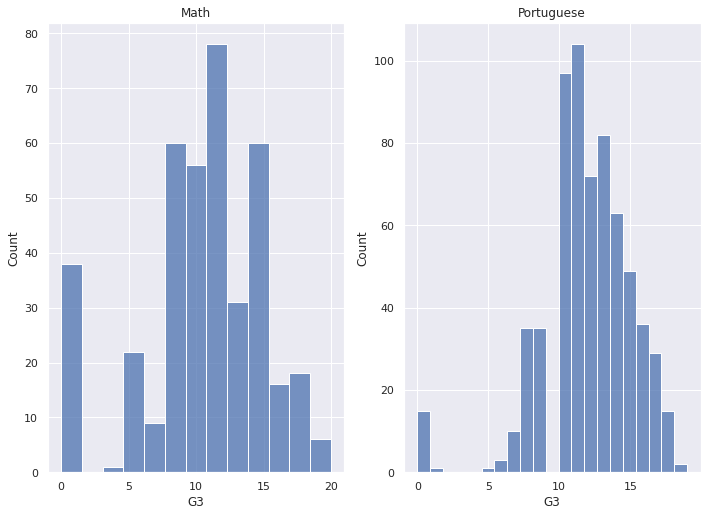

In [2080]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

fig, ax = plt.subplots(1,2)
sns.histplot(x='G3', data=maths_df, ax=ax[0])

ax[0].set_title("Math") 

sns.histplot(x='G3', data=portuguese_df, ax=ax[1])

ax[1].set_title("Portuguese") 

plt.show()

### Correlation plots
From the correlation plot for **math** we can see, that unsurprisingly, mother's and father's education are strongly correlated. There are some significant correlations in (going out, drinking during weekends, drinking during workday). As mentioned before, G1, G2 and G3 are strongly correlated. Parent's education is weekly correlated with student's results. Previous failures are negatively correlated with the results.  Interestingly, there is only very week correlation between absences, study time, drinking alcohol and student's results.

When looking at the correlation plot for **Portuguese**, there isn't that much difference when comparing to math with exception of student's result correlations to different life conditions - so study time, parents' education and drinking behaviours seem to become more important. 

**Possible hypothesis**: math results are more about student's 'intelligence' or 'innate abilities' than portuguese results.

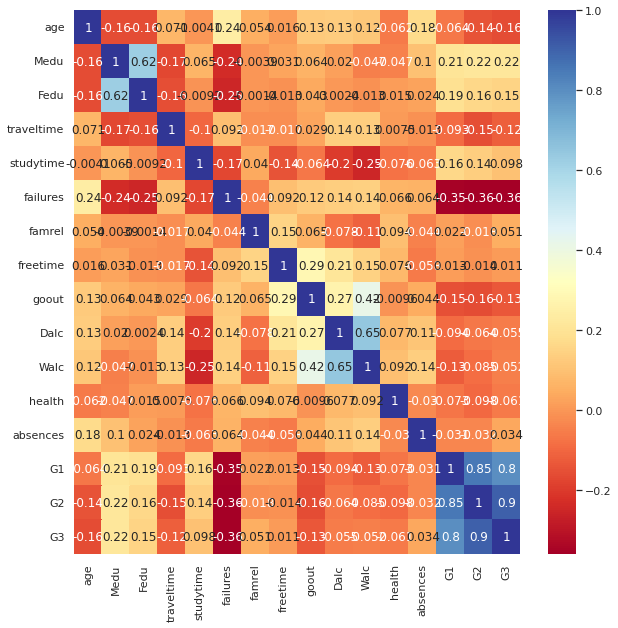

In [2081]:
plt.figure(figsize=(10, 10))
sns.heatmap(maths_df.corr(), cbar=True, annot=True, cmap='RdYlBu')

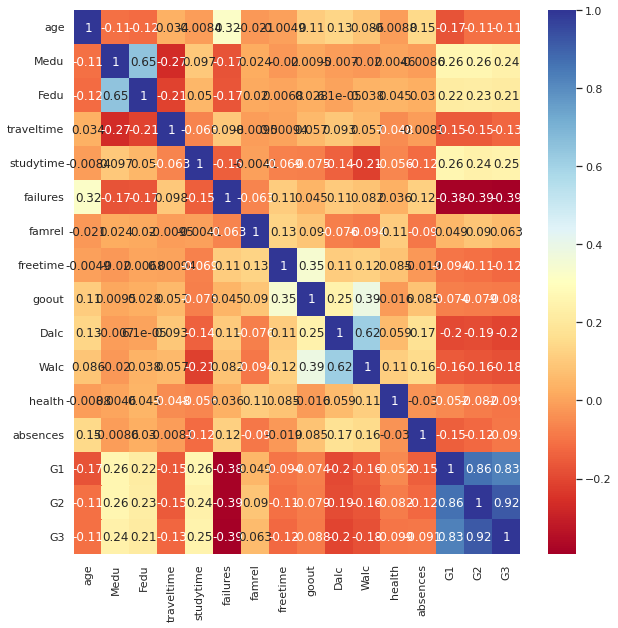

In [2082]:
plt.figure(figsize=(10, 10))
sns.heatmap(portuguese_df.corr(), cbar=True, annot=True, cmap='RdYlBu')

### More detailed investigation
We will now investigate interesting features further and look at categorical data.

In [2083]:
def plot_values(x: str, x_name: str):
  sns.set(rc={'figure.figsize':(11.7,8.27)})

  fig, ax = plt.subplots(1,2)
  sns.boxplot(x=x, y='G3', data=maths_df, ax=ax[0])

  ax[0].set_xlabel(x_name)
  ax[0].set_ylabel("Results")

  ax[0].set_title("Math") 

  sns.boxplot(x=x, y='G3', data=portuguese_df, ax=ax[1])

  ax[1].set_xlabel(x_name)
  ax[1].set_ylabel("Results")

  ax[1].set_title("Portuguese") 

  plt.show()

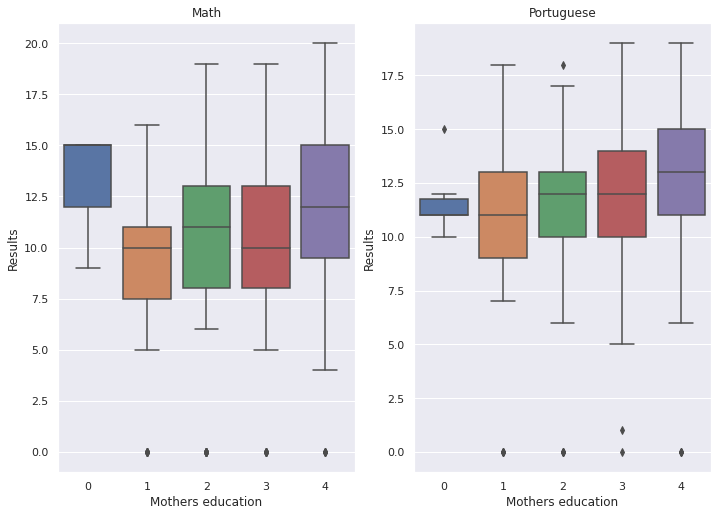

In [2084]:
plot_values('Medu', 'Mothers education')

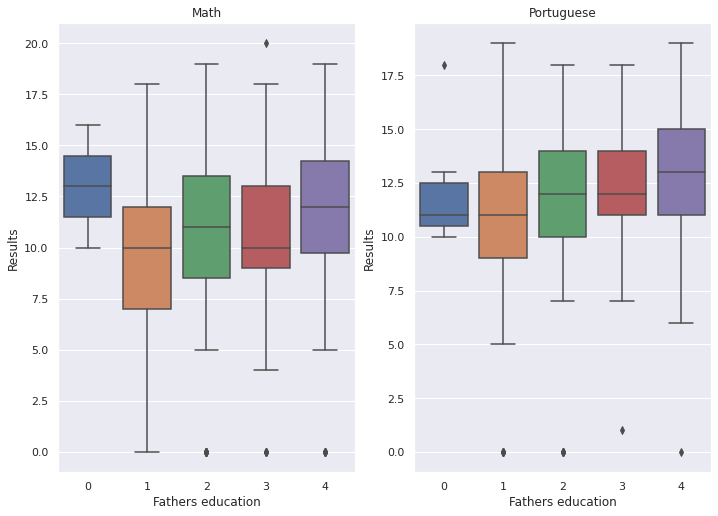

In [2085]:
plot_values('Fedu', 'Fathers education')

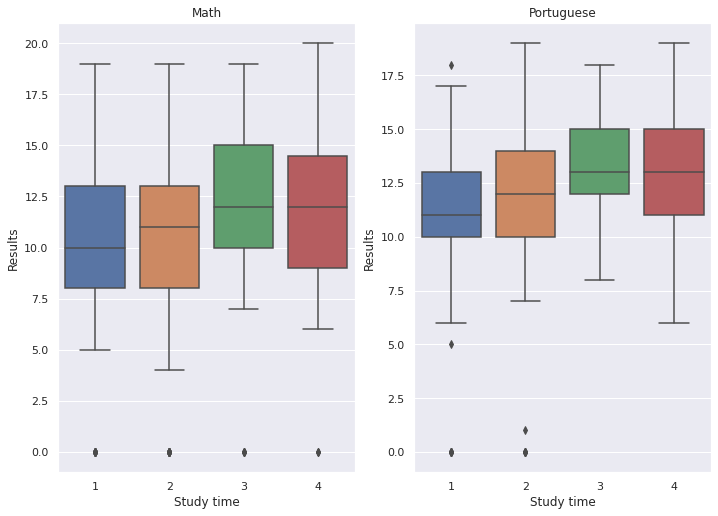

In [2086]:
plot_values('studytime', 'Study time')

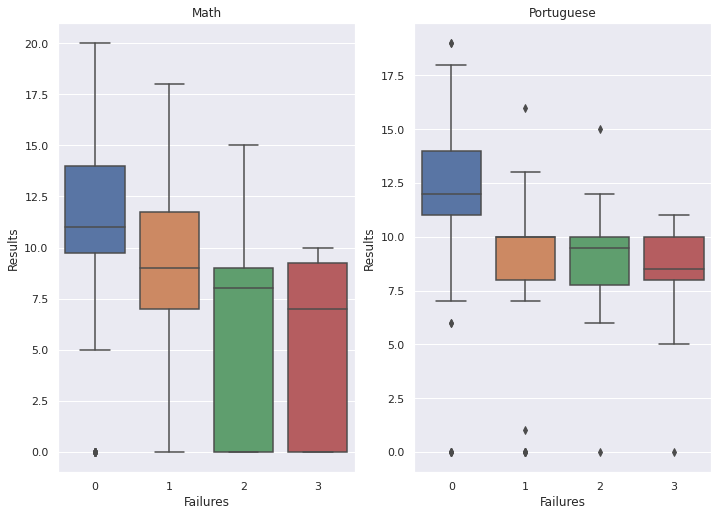

In [2087]:
plot_values('failures', 'Failures')

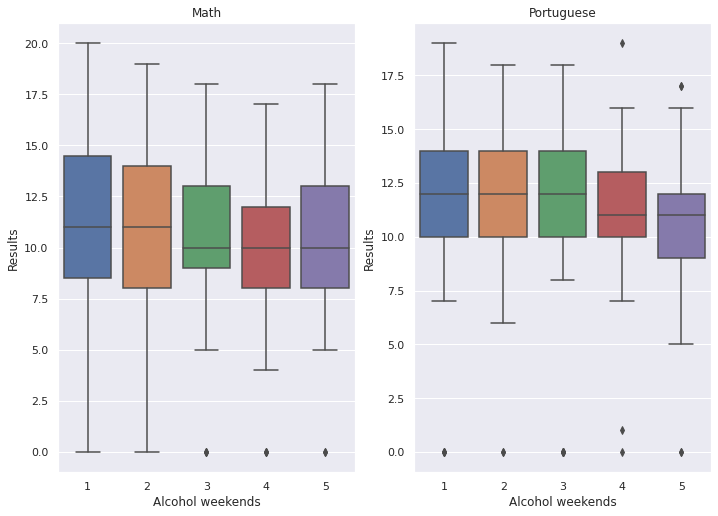

In [2088]:
plot_values('Walc', 'Alcohol weekends')

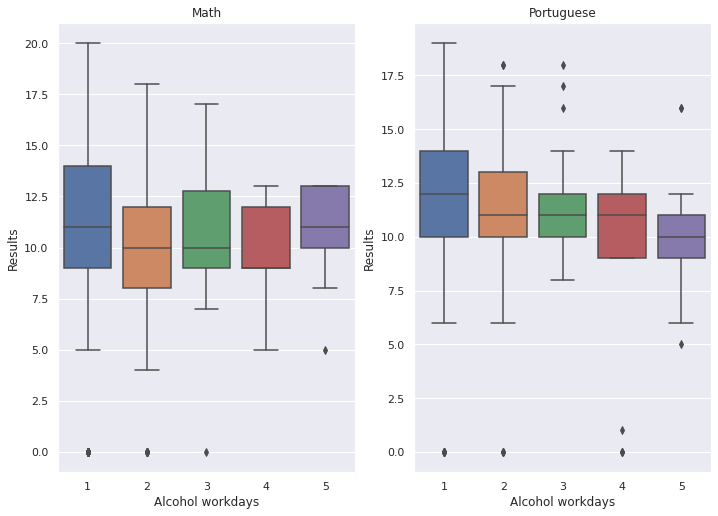

In [2089]:
plot_values('Dalc', 'Alcohol workdays')

**Let's also do the plots for categorical variables**

Possible that GP is a better school overall.

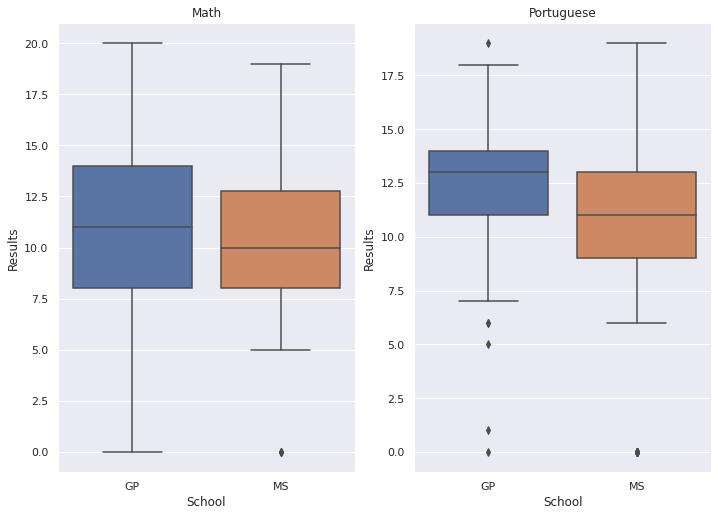

In [2090]:
plot_values('school', 'School')

Possible that females are better at humanities and males better at maths.

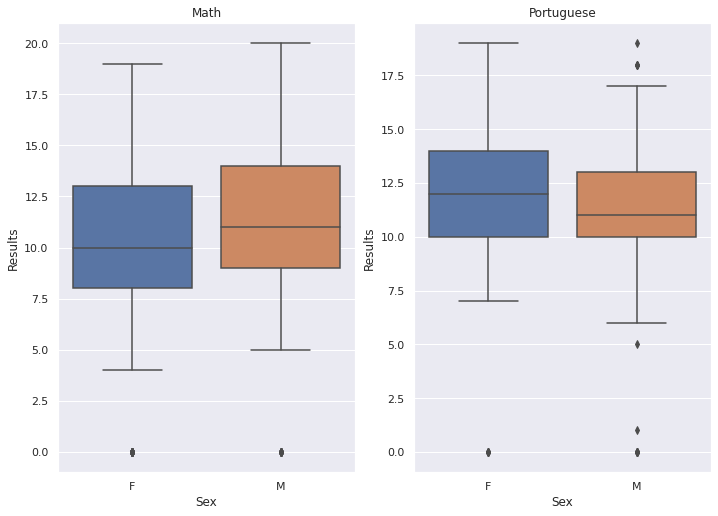

In [2091]:
plot_values('sex', 'Sex')

Possible that people from urban areas are performing better.

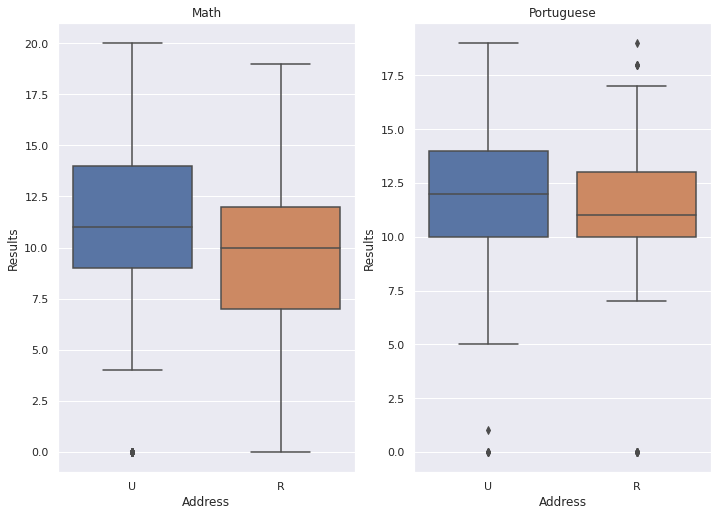

In [2092]:
plot_values('address', 'Address')

Family size seems irrelevant.

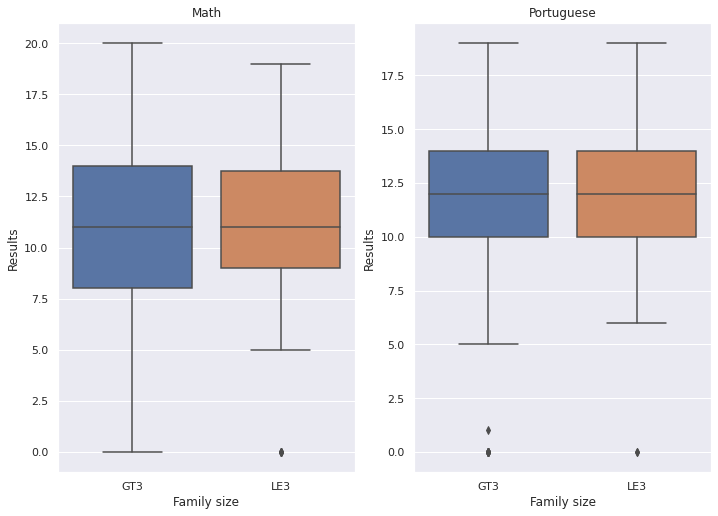

In [2093]:
plot_values('famsize', 'Family size')

Parents living apart or together seem irrelevant.

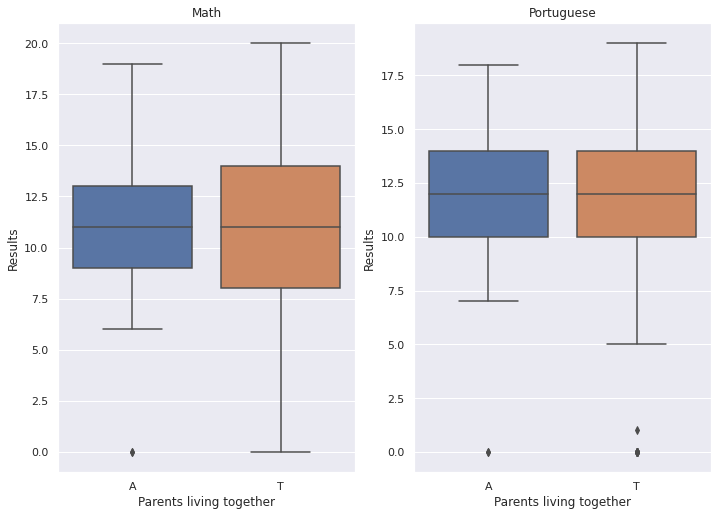

In [2094]:
plot_values('Pstatus', 'Parents living together')

It has been shown in other studies that children whose mothers don't work tend to perform worse in school. Seems that having mother working in health services might be correlated with better performance.

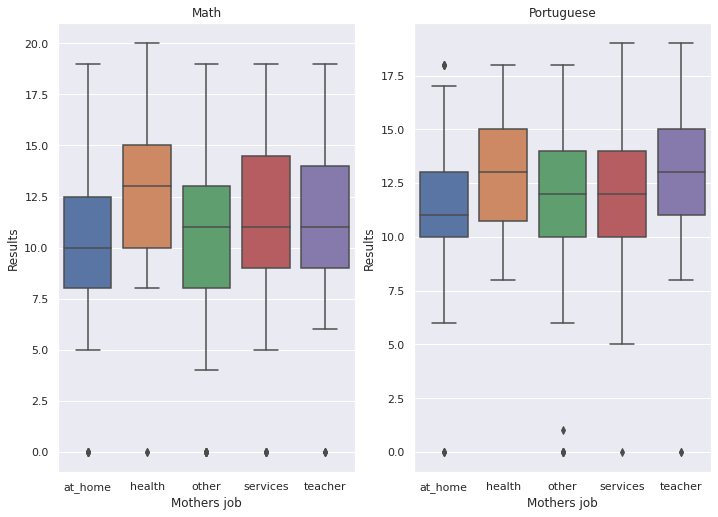

In [2095]:
plot_values('Mjob', 'Mothers job')

Seems like having a father who is a teacher might be correlated with better test results.

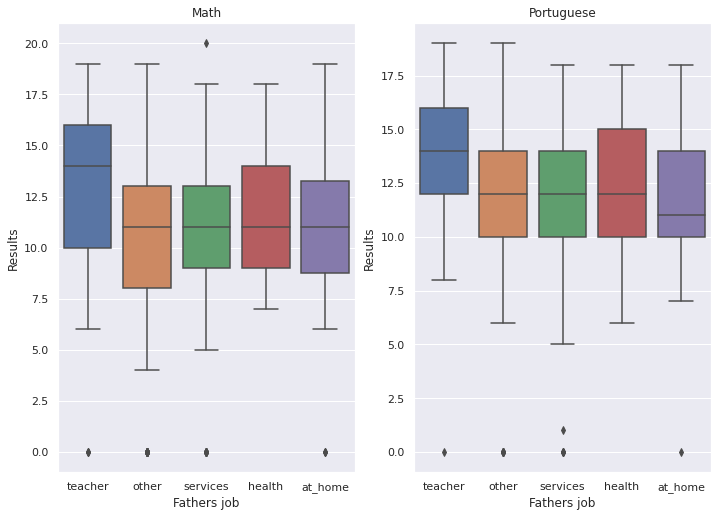

In [2096]:
plot_values('Fjob', 'Fathers job')

Reason for choosing a school seems more relevant in the context of Porutuese than math.

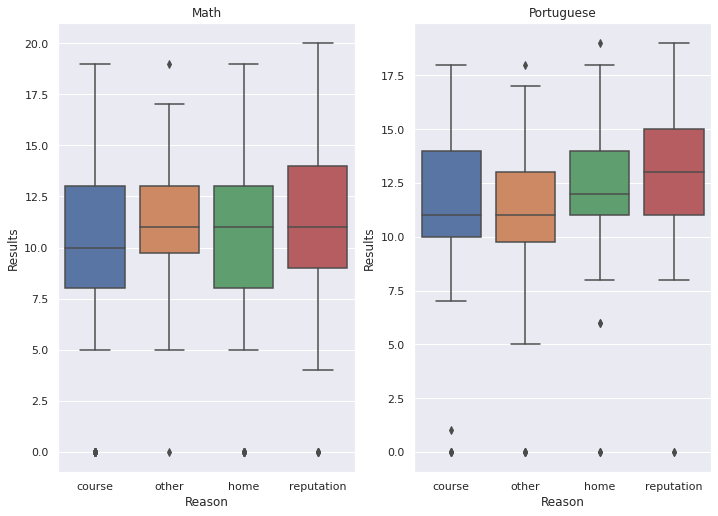

In [2097]:
plot_values('reason', 'Reason')

Children with complicated guardianship situation seem to perform worse.

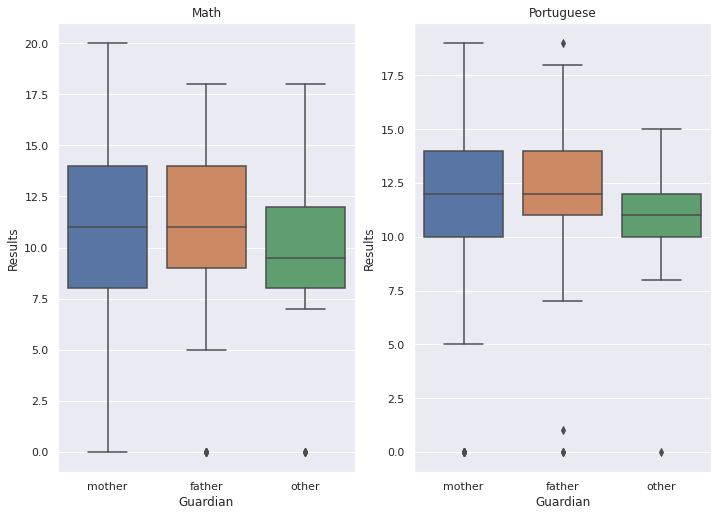

In [2098]:
plot_values('guardian', 'Guardian')

School's additional support seems negatively correlated with performance.

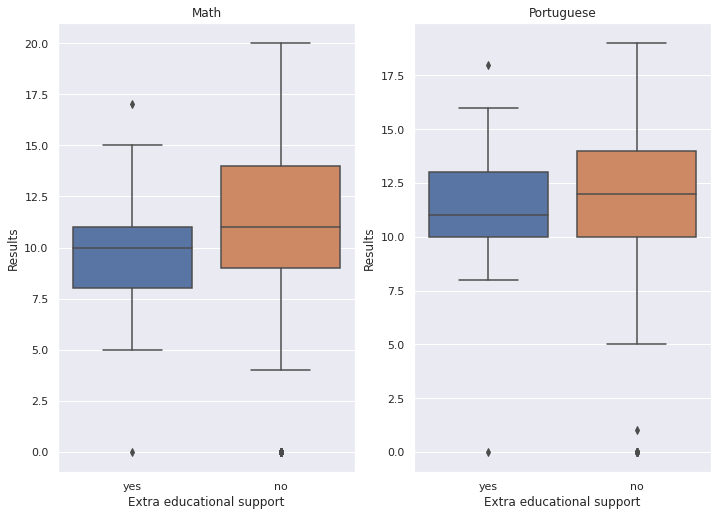

In [2099]:
plot_values('schoolsup', 'Extra educational support')

Family support doesn't seem that much correlated.

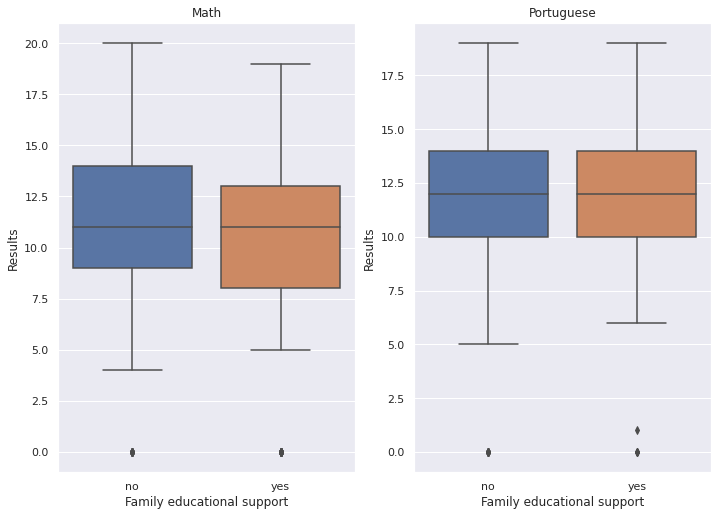

In [2100]:
plot_values('famsup', 'Family educational support')

Extra paid classes don't seem that much correlated.

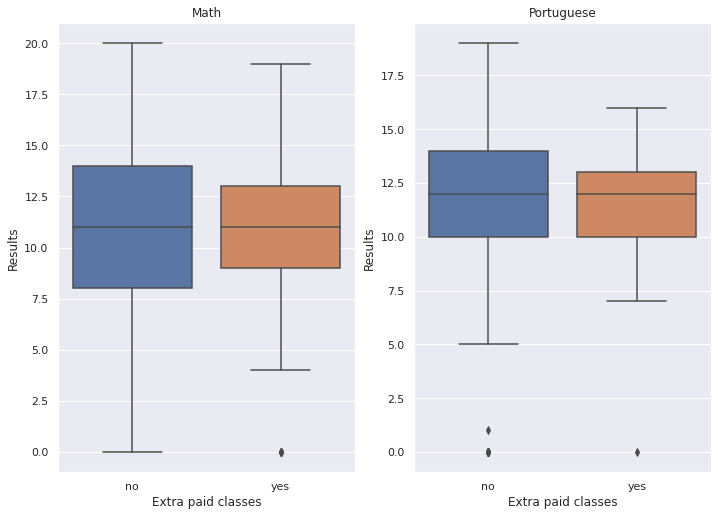

In [2101]:
plot_values('paid', 'Extra paid classes')

Attending nursery doesn't look to important.

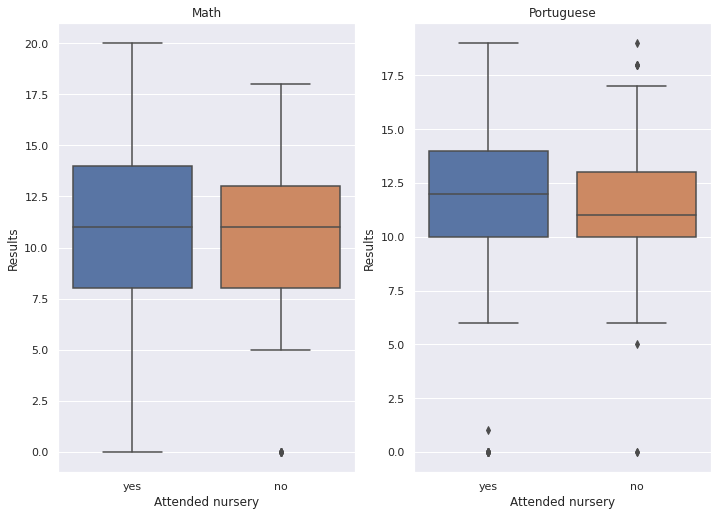

In [2102]:
plot_values('nursery', 'Attended nursery')

Wanting higher education seems extremely important for test performance.

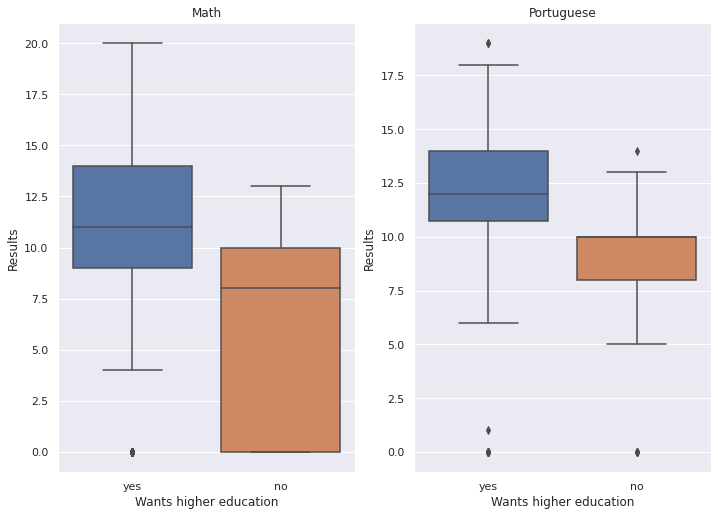

In [2103]:
plot_values('higher', 'Wants higher education')

Internet access looks correlated with test results. 

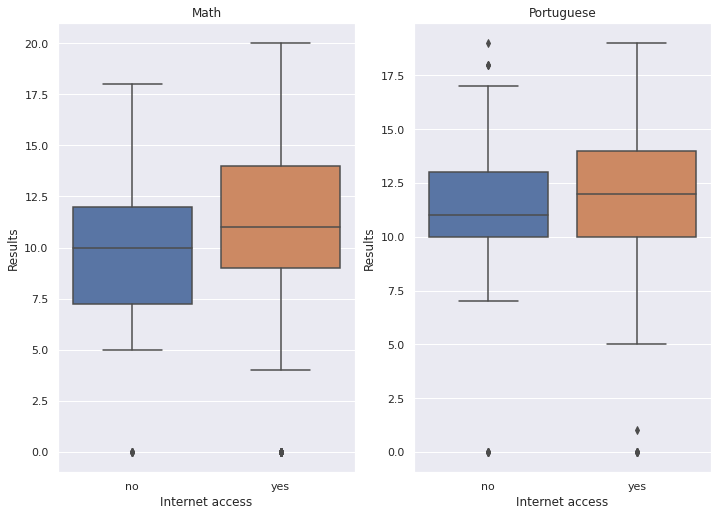

In [2104]:
plot_values('internet', 'Internet access')

Being in relationship doesn't seem too important especially for results in Portuguese.

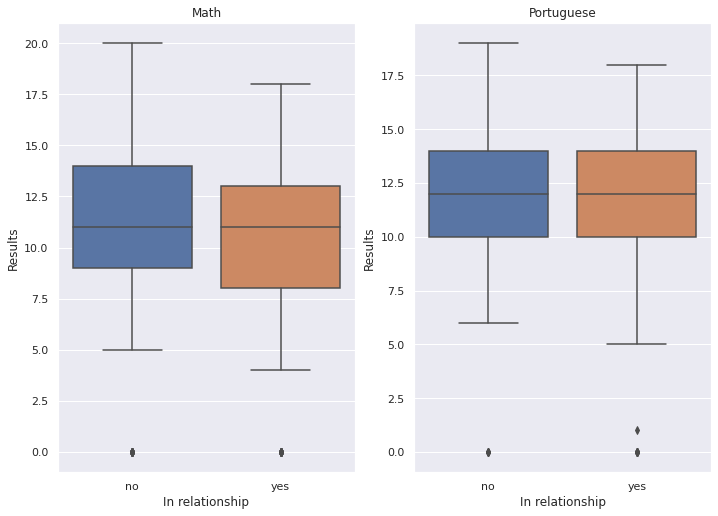

In [2105]:
plot_values('romantic', 'In relationship')

## **Feature engineering**
Now we will do some minimal feature engineering.

In [2106]:
math_x = maths_df.drop(['G3', 'G2', 'G1'], axis = 1)
port_x = portuguese_df.drop(['G3', 'G2', 'G1'], axis = 1)
math_y = maths_df[['G3']]
port_y = portuguese_df[['G3']]

Categorical variables need to be encoded.

In [2107]:
def encode_categorical(df):
    df = df.copy()
    
    df = df.replace({'GP': 0, 'MS': 1})
    df = df.replace({'F': 0, 'M': 1})
    df = df.replace({'U': 0, 'R': 1})
    df = df.replace({'LE3': 0, 'GT3': 1})
    df = df.replace({'A': 0, 'T': 1})
    df = df.replace({'no': 0, 'yes': 1})
    
    onehot_features = ['Mjob', 'Fjob', 'reason', 'guardian']
    df = pd.concat([df, pd.get_dummies(df[onehot_features])], axis=1)
    df = df.drop(onehot_features, axis=1)

    return df

In [2108]:
math_x = encode_categorical(math_x)
port_x = encode_categorical(port_x)

There is little data available. There is much more data about results from portuguese than from math. For that reason, we are going to train our models using both datasets at once and then test them separately.

In [2109]:
print(len(port_x))
print(len(math_x))

649
395


We are quite sure, that portuguese will have a different distribution than math. Therefore we add a feature for that.

In [2110]:
math_x['portuguese'] = 0
port_x['portuguese'] = 1

math_x_train, math_x_test, math_y_train, math_y_test = train_test_split(math_x, math_y, train_size=0.8, shuffle=True)
port_x_train, port_x_test, port_y_train, port_y_test = train_test_split(port_x, port_y, train_size=0.8, shuffle=True)


Since we merge training data for portuguese and math, we resample math data, to have a more balance dataset. We scale the results for maths and portuguese to have both mean 0 and standard deviation 1.

In [2111]:
maths_train = math_x_train
maths_train['G3'] = math_y_train

maths_train = pd.concat([resample(maths_train, n_samples = len(maths_train)), maths_train], axis = 0)
math_x_train = maths_train.drop(['G3'], axis=1)
math_y_train = maths_train[['G3']]

x_train = pd.concat([math_x_train, port_x_train], axis = 0)
y_train = pd.concat([(math_y_train - math_y_train.values.mean()) / math_y_train.values.std(), (port_y_train - port_y_train.values.mean())  / port_y_train.values.std()], axis = 0)

In [2112]:
def scale(train, test):
    scaler = StandardScaler()
    n_train = pd.DataFrame(scaler.fit_transform(train), index=train.index, columns=train.columns)
    n_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)

    return n_train, n_test

We scale the features so that all the columns are on the same scale.

In [2113]:
_, math_x_test = scale(x_train, math_x_test)
x_train, port_x_test = scale(x_train, port_x_test)

We select most important features.

In [2114]:
estimator = XGBRegressor(objective='reg:squarederror')
rfe = RFECV(estimator=estimator, min_features_to_select=5, step=1, cv=5)
rfe.fit(x_train, y_train)
support = rfe.support_
x_train = x_train.loc[:, support]
port_x_test = port_x_test.loc[:, support]
math_x_test = math_x_test.loc[:, support]

## *Create and evaluate models*
We train three different models - linear regression, random forst and boosted trees. We select the best model for each subject by looking at the RMSE.

In [2115]:
models = {
    'Regression': LinearRegression(),
    'Forest': RandomForestRegressor(),
    'Boosting': XGBRegressor(objective='reg:squarederror')
}

for name, model in models.items():
    model.fit(x_train,y_train)

for name, model in models.items():
    port_y_pred = port_y_train.values.std() * model.predict(port_x_test) + port_y_train.values.mean()
    print(name + " Portuguese RMSE: {:.2f}\n".format(np.sqrt(mean_squared_error(port_y_test, port_y_pred))))

    math_y_pred = math_y_train.values.std() * model.predict(math_x_test) + math_y_train.values.mean()
    print(name + " Math RMSE: {:.2f}\n".format(np.sqrt(mean_squared_error(math_y_test, math_y_pred))))

Regression Portuguese RMSE: 3.02

Regression Math RMSE: 3.89

Forest Portuguese RMSE: 2.98

Forest Math RMSE: 3.10

Boosting Portuguese RMSE: 2.95

Boosting Math RMSE: 3.05



### Results
Model's performance is not perfect, though results look far better than random. It looks like a big part of the problem is model not predicting small values.

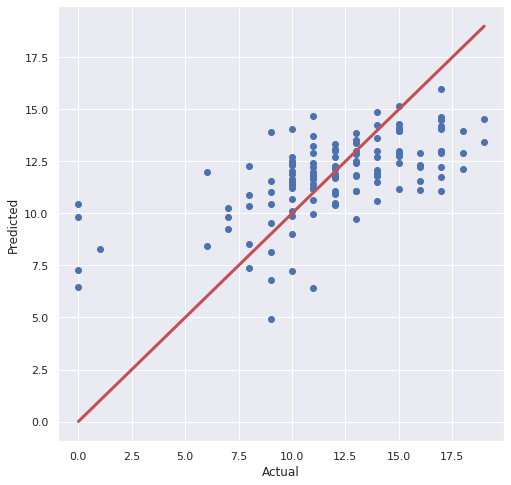

In [2116]:
model = models['Boosting']
plt.figure(figsize=(8, 8))
plt.scatter(port_y_test, port_y_pred)
plt.plot([port_y_test.min(), port_y_test.max()], [port_y_test.min(), port_y_test.max()], c='r', lw=3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

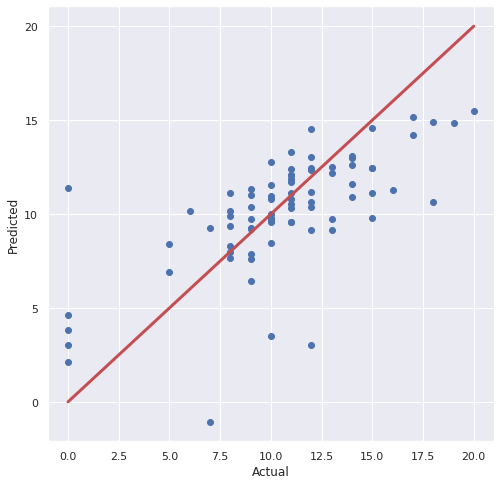

In [2117]:
model = models['Boosting']
y_pred = model.predict(math_x_test)
plt.figure(figsize=(8, 8))
plt.scatter(math_y_test, math_y_pred)
plt.plot([math_y_test.min(), math_y_test.max()], [math_y_test.min(), math_y_test.max()], c='r', lw=3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()